#### 앙상블
- 여러 개의 분류기를 생성하고 각 예측들을 결합함으로써 보다 정확한 예측을 도출하는 기법

#### 랜덤포레스트
- 훈련 세트로부터 무작위로 각기 다른 서브셋을 만들어 일련의 결정 트리 분류기를 훈련시킴.
- 모든 개별 트리의 예측을 구하고, 가장 많은 선택을 받은 클래스를 예측으로 삼음.
- 이러한 결정 트리의 앙상블을 랜덤 포레스트라고 함.

# 7.1 투표 기반 분류기

다음은 여러 분류기를 조합하여 사이킷런의 투표 기반 분류기(VotingClassifier)를 만들고 훈련시키는 코드입니다. (p. 248)

In [1]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

In [2]:
# moons 데이터셋을 불러와줍니다.
from sklearn.model_selection import train_test_split
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=500, noise=0.30, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

#### voting classifier 클래스 이용
* 매개변수:
    * ```estimators```: 앙상블할 모델들을 설정. ('분류기 이름', 분류기)의 튜플을 리스트로 묶어서 전달
    * voting: voting방식 (default: ```voting='hard'``` / 지정: ```voting='soft'```)

### 1) 직접 투표_Hard Voting

In [3]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(random_state=42)

voting_clf = VotingClassifier(
    estimators =[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='hard')
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(random_state=42))])

In [4]:
# 각 분류기의 테스트셋 정확도를 확인.
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))      # accuracy_score(실제라벨 결과, 예측라벨 결과)

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.912


'투표 기반 분류기가 다른 개별 분류기보다 성능이 조금 더 높습니다'

### 2) 간접 투표_Soft Voting
- 모든 분류기가 클래스의 확률을 예측할 수 있을 때, 개별 분류기의 예측을 평균 내어 확률이 가장 높은 클래스를 예측하는 방식
- 확률이 높은 투표에 비중을 더 두기 때문에 직접 투표 방식보다 성능이 높음
- ```voting='hard'```→```voting='soft'```
- SVM은 클래스 확률을 제공하지 않으므로 ```probability``` 매개변수를 True로 지정해야 함

In [5]:
log_clf = LogisticRegression(random_state=42)
rnd_clf = RandomForestClassifier(random_state=42)
svm_clf = SVC(probability=True, random_state=42)    #SVC(probability=True)

voting_clf = VotingClassifier(
    estimators =[('lr', log_clf), ('rf', rnd_clf), ('svc', svm_clf)],
    voting='soft')                                   #voting='soft'
voting_clf.fit(X_train, y_train)

VotingClassifier(estimators=[('lr', LogisticRegression(random_state=42)),
                             ('rf', RandomForestClassifier(random_state=42)),
                             ('svc', SVC(probability=True, random_state=42))],
                 voting='soft')

In [6]:
# 각 분류기의 테스트셋 정확도를 확인.
from sklearn.metrics import accuracy_score
for clf in (log_clf, rnd_clf, svm_clf, voting_clf):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(clf.__class__.__name__, accuracy_score(y_test, y_pred))      # accuracy_score(실제라벨 결과, 예측라벨 결과)

LogisticRegression 0.864
RandomForestClassifier 0.896
SVC 0.896
VotingClassifier 0.92


## 7.2.1 사이킷런의 배깅과 페이스팅
다음은 결정 트리 분류기 500개의 앙상블을 훈련시키는 코드입니다. 각 분류기는 훈련 세트에서 중복을 허용하여 무작위로 선택된 100개의 샘플로 훈련됩니다(이는 배깅의 경우고, 대신 페이스팅을 사용하려면 bootstrap=False로 지정하면 됩니다). n_jobs 매개변수는 사이킷런이 훈련과 예측에 사용할 CPU 코어 수를 지정합니다(-1로 지정하면 가용한 모든 코어를 사용합니다). (p. 251)

#### Bagging을 이용한 앙상블 학습

In [7]:
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    max_samples=100, bootstrap=True, random_state=42)    #bootstrap=False로 지정하면 배깅 대신 페이스팅을 사용할 수 있음
bag_clf.fit(X_train, y_train)
y_pred = bag_clf.predict(X_test)

print('Accuracy =', accuracy_score(y_test, y_pred))

Accuracy = 0.904


#### 단일 결정 트리

In [8]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(random_state=42)
tree_clf.fit(X_train, y_train)
y_pred_tree = tree_clf.predict(X_test)
print('Accuracy =', accuracy_score(y_test, y_pred_tree))

Accuracy = 0.856


#### 단일 결정 트리(왼쪽)와 500개 트리로 만든 배깅 앙상블(오른쪽) 비교

In [9]:
from matplotlib.colors import ListedColormap
import matplotlib.pyplot as plt

def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

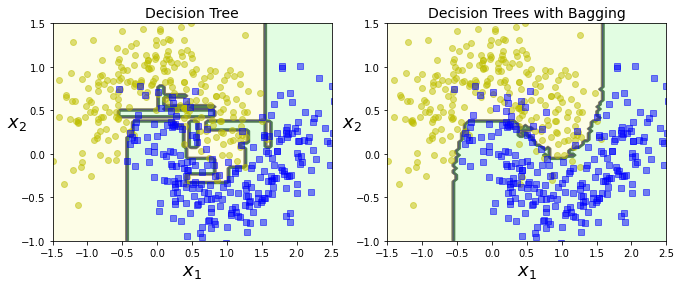

In [10]:
import numpy as np
import warnings
warnings.filterwarnings(action='ignore')

plt.figure(figsize=(11,4))
plt.subplot(121)
plot_decision_boundary(tree_clf, X, y)
plt.title("Decision Tree", fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, X, y)
plt.title("Decision Trees with Bagging", fontsize=14)
plt.show()

♣ NOTE: BaggingClassifier는 기반이 되는 분류기가 결정 트리 분류기처럼 클래스 확률을 추정할 수 있으면(즉, predict_proba()함수가 있으면) 직접 투표 대신 자동으로 간접 투표 방식을 사용합니다.

- 각 분류기가 weak learner(약한 학습기)일지라도, 충분하게 많고 다양하다면 앙상블은 strong learner(강한 학습기)가 될 수 있다.
- 근거: 큰 수의 법칙
    - 시행의 크기를 충분히 늘리면 사건이 발생할 확률은 수학적 확률에 수렴한다는 이론.

Question. 배깅과 페이스팅 중 어느 것을 쓰는 것이 좋을까?

## 7.2.2 oob 평가
사이킷런에서 BaggingClassifier를 만들 때 ```oob_socre=True```로 지정하면 훈련이 끝난 후 자동으로 oob 평가를 수행합니다. 다음 코드는 이 과정을 보여줍니다. 평가 점수 결과는 ```oob_score_``` 변수에 저장되어 있습니다. (p.252)

#### oob_out of bag 샘플:
- 배깅의 '중복 허용'하는 특성에서 비롯됨.
- BaggingClassifier에서, 평균적으로 각 예측기에 훈련 샘플의 63% 정도만 샘플링됨. 
- 선택되지 않은 훈련 샘플의 나머지 37%를 oob 샘플이라고 부름(예측기마다 남겨진 37%는 모두 다름).
- 별도의 검증 세트를 사용하지 않고 예측기의 performance를 확인할 수 있음.

In [11]:
# oob 평가 수행
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(), n_estimators=500,
    bootstrap=True, oob_score=True, random_state=42)      #oob_score=True
bag_clf.fit(X_train, y_train)
bag_clf.oob_score_

0.896

In [12]:
# 테스트셋 정확도
from sklearn.metrics import accuracy_score
y_pred = bag_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.92

oob 샘플에 대한 결정 함수(각 훈련 샘플의 클래스 확률을 반환함)의 값도 ```oob_decision_function_``` 변수에서 확인할 수 있습니다.

In [13]:
bag_clf.oob_decision_function_

array([[0.32352941, 0.67647059],
       [0.3375    , 0.6625    ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.        , 1.        ],
       [0.06145251, 0.93854749],
       [0.35465116, 0.64534884],
       [0.01142857, 0.98857143],
       [0.98930481, 0.01069519],
       [0.97927461, 0.02072539],
       [0.75586854, 0.24413146],
       [0.0049505 , 0.9950495 ],
       [0.75520833, 0.24479167],
       [0.82122905, 0.17877095],
       [0.98461538, 0.01538462],
       [0.06315789, 0.93684211],
       [0.00490196, 0.99509804],
       [0.99004975, 0.00995025],
       [0.92513369, 0.07486631],
       [1.        , 0.        ],
       [0.03409091, 0.96590909],
       [0.35087719, 0.64912281],
       [0.91111111, 0.08888889],
       [1.        , 0.        ],
       [0.96319018, 0.03680982],
       [0.        , 1.        ],
       [1.        , 0.        ],
       [1.        , 0.        ],
       [0.        , 1.        ],
       [0.6635514 , 0.3364486 ],
       [0.

# 7.3 랜덤 패치와 랜덤 서브스페이스

#### 랜덤 패치:
- 훈련 특성과 샘플을 모두 샘플링하는 것
- ```bootstrap=True```, ```bootstrap_features=True```

#### 랜덤 서브스페이스:
- 훈련 샘플을 모두 사용하고 특성은 샘플링하는 것
- ```bootstrap=False```, ```bootstrap_features=True```

특성 샘플링은 더 다양한 예측기를 만들며 편향을 늘리는 대신 분산을 낮춤.

# 7.4 랜덤 포레스트

다음은 (최대 16개의 리프 노드를 갖는) 500개 트리로 이뤄진 랜덤 포레스트 분류기를 여러 CPU 코어에서 훈련시키는 코드입니다.(p. 254)

In [14]:
# RandomClassifier
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1)
rnd_clf.fit(X_train, y_train)

y_pred_rf = rnd_clf.predict(X_test)

다음은 BaggingClassifier를 사용해 앞의 RandomForestClassifier와 거의 유사하게 만든 것입니다.(p. 255)

In [15]:
# BaggingClassifier > DecisionTreeClassifier
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(max_features='auto', max_leaf_nodes=16),
    n_estimators=500, max_samples=1.0, bootstrap=True, n_jobs=-1)

## 7.4.1 엑스트라 트리(익스트림 랜덤 트리)
랜덤 포레스트에서 트리가 성장할 때 각 노드에서 특성의 일부를 무작위로 선택해 분할에 사용함.
* 일반 결정 트리: 가능한 **최선의 임계점**을 찾음.
* 엑스트라 트리
    * 각 특성에 대해 **랜덤한 임계점**을 사용함.
    * 랜덤 포레스트가 훈련 데이터에 과대적합되는 경우를 피할 수 있음.
    * 랜덤 포레스트보다 훨씬 빠르게 훈련됨(예측할 때의 속도는 변함이 없음).

## 7.4.2 특성 중요도

예를 들어 다음 코드는 (4장에서 소개한) iris 데이터셋에 RandomForestClassifier를 훈련시키고 각 특성의 중요도를 출력합니다.(p. 256)

In [16]:
from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1)
rnd_clf.fit(iris['data'], iris['target'])
for name, score in zip(iris['feature_names'], rnd_clf.feature_importances_):
    print(name, score)
    
# sepal: 꽃받침
# petal: 꽃잎

sepal length (cm) 0.09574115889105018
sepal width (cm) 0.02413722925552473
petal length (cm) 0.44351207578282886
petal width (cm) 0.43660953607059616


RandomForestClassifier에서는 불순도 감소를 연관된 훈련 샘플의 수로 가중치를 부여하여 평균을 내고 특성 중요도의 전체 합이 1이 되도록 해서 특성의 상대적 중요도를 ```feature_importances_``` 속성에 저장한다.

# 7.5 부스팅
* 약한 학습기를 여러 개 연결하여 강한 학습기를 만드는 앙상블 방법.
* 앞의 모델을 보완해나가면서 일련의 예측기를 학습시킴.
1. 에이다부스트
2. 그레이디언트 부스팅

## 7.5.1 에이다부스트
- 이전 모델이 과소적합했던 훈련 샘플의 가중치를 더 높임.
- 새로운 예측기는 학습하기 어려운 샘플에 점점 더 맞춰지게 됨.

[AdaBoost Math with Example clearly explained Step by Step Machine Learning Ensembles]
https://www.youtube.com/watch?v=peh2l4dePBc

In [17]:
from sklearn.ensemble import AdaBoostClassifier

ada_clf = AdaBoostClassifier(
        DecisionTreeClassifier(max_depth=1), n_estimators=200,
    algorithm="SAMME.R", learning_rate=0.5)
ada_clf.fit(X_train, y_train)

AdaBoostClassifier(base_estimator=DecisionTreeClassifier(max_depth=1),
                   learning_rate=0.5, n_estimators=200)

## 7.5.2 그레이디언트 부스팅
- 에이다부스트처럼 앙상블에 이전까지의 오차를 보정하도록 예측기를 순차적으로 추가함.
- 반복마다 샘플의 가중치 수정(X).
- 이전 예측기가 만든 **잔여 오차**에 새로운 예측기를 학습시킴.

결정 트리를 기반 예측기로 사용하는 간단한 회귀 문제를 풀어보겠습니다. (...) 먼저 DecisionTreeRegressor를 훈련 세트에 학습시켜 보겠습니다.

$$y=3X^2 + 0.05 + noise$$

In [18]:
np.random.seed(42)
X = np.random.rand(100, 1) - 0.5
y = 3*X[:, 0]**2 + 0.05 * np.random.randn(100)

In [19]:
from sklearn.tree import DecisionTreeRegressor

tree_reg1 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg1.fit(X, y)

DecisionTreeRegressor(max_depth=2, random_state=42)

이제 첫 번째 예측기에서 생긴 잔여 오차에 두 번째 DecisionTreeRegressor를 훈련시킵니다.

In [20]:
y2 = y - tree_reg1.predict(X)  # 첫 번째 예측기가 만든 잔여 오차

tree_reg2 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg2.fit(X, y2)

DecisionTreeRegressor(max_depth=2, random_state=42)

그런 다음 두 번째 예측기가 만든 잔여 오차에 세 번째 회귀 모델을 훈련시킵니다.

In [21]:
y3 = y2 - tree_reg2.predict(X)  # 두 번째 예측기가 만든 잔여 오차

tree_reg3 = DecisionTreeRegressor(max_depth=2, random_state=42)
tree_reg3.fit(X, y3)

DecisionTreeRegressor(max_depth=2, random_state=42)

이제 세 개의 트리를 포함하는 앙상블 모델이 생겼습니다. 새로운 샘플에 대한 예측을 만들려면 모든 트리의 예측을 더하면 됩니다.

In [22]:
X_new = np.array([[0.8]])  # new data

y_pred = sum(tree.predict(X_new) for tree in (tree_reg1, tree_reg2, tree_reg3))
print('y_pred :', y_pred)

y_pred : [0.75026781]


사이킷런의 GradientBoostingRegressor를 사용하면 GBRT 앙상블을 간단하게 훈련시킬 수 있습니다. (...) 다음은 이전에 만든 것과 같은 앙상블을 만드는 코드입니다. (p. 263)

In [23]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1.0)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1.0, max_depth=2, n_estimators=3)

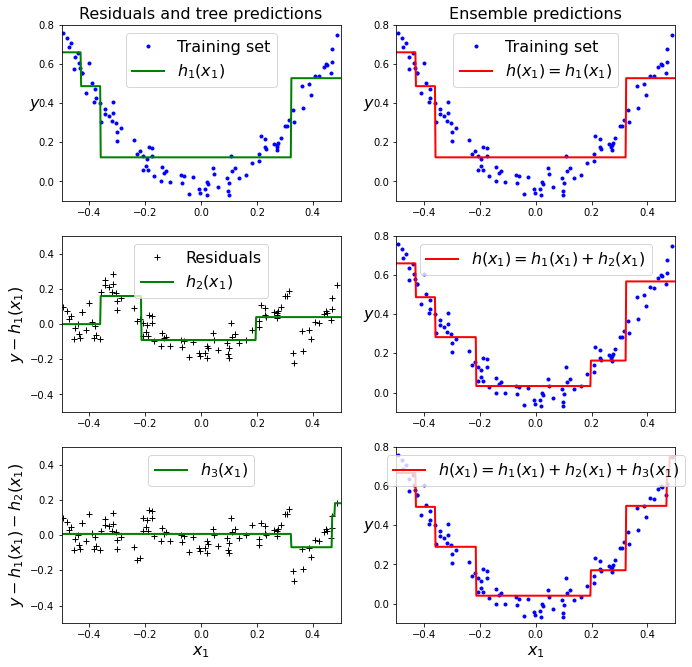

In [24]:
import warnings
warnings.filterwarnings(action='ignore')

def plot_predictions(regressors, X, y, axes, label=None, style="r-", data_style="b.", data_label=None):
    x1 = np.linspace(axes[0], axes[1], 500)
    y_pred = sum(regressor.predict(x1.reshape(-1, 1)) for regressor in regressors)
    plt.plot(X[:, 0], y, data_style, label=data_label)
    plt.plot(x1, y_pred, style, linewidth=2, label=label)
    if label or data_label:
        plt.legend(loc="upper center", fontsize=16)
    plt.axis(axes)

plt.figure(figsize=(11,11))

plt.subplot(321)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h_1(x_1)$", style="g-", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Residuals and tree predictions", fontsize=16)

plt.subplot(322)
plot_predictions([tree_reg1], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1)$", data_label="Training set")
plt.ylabel("$y$", fontsize=16, rotation=0)
plt.title("Ensemble predictions", fontsize=16)

plt.subplot(323)
plot_predictions([tree_reg2], X, y2, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_2(x_1)$", style="g-", data_style="k+", data_label="Residuals")
plt.ylabel("$y - h_1(x_1)$", fontsize=16)

plt.subplot(324)
plot_predictions([tree_reg1, tree_reg2], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1)$")
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.subplot(325)
plot_predictions([tree_reg3], X, y3, axes=[-0.5, 0.5, -0.5, 0.5], label="$h_3(x_1)$", style="g-", data_style="k+")
plt.ylabel("$y - h_1(x_1) - h_2(x_1)$", fontsize=16)
plt.xlabel("$x_1$", fontsize=16)

plt.subplot(326)
plot_predictions([tree_reg1, tree_reg2, tree_reg3], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="$h(x_1) = h_1(x_1) + h_2(x_1) + h_3(x_1)$")
plt.xlabel("$x_1$", fontsize=16)
plt.ylabel("$y$", fontsize=16, rotation=0)

plt.show()

## LEARNING RATE

In [25]:
from sklearn.ensemble import GradientBoostingRegressor

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=3, learning_rate=1, random_state=42)
gbrt.fit(X, y)

GradientBoostingRegressor(learning_rate=1, max_depth=2, n_estimators=3,
                          random_state=42)

In [26]:
print('y_pred :', gbrt.predict(X_new))

y_pred : [0.75026781]


In [27]:
gbrt_slow = GradientBoostingRegressor(max_depth=2, n_estimators=200, learning_rate=0.1, random_state=42)
gbrt_slow.fit(X, y)

GradientBoostingRegressor(max_depth=2, n_estimators=200, random_state=42)

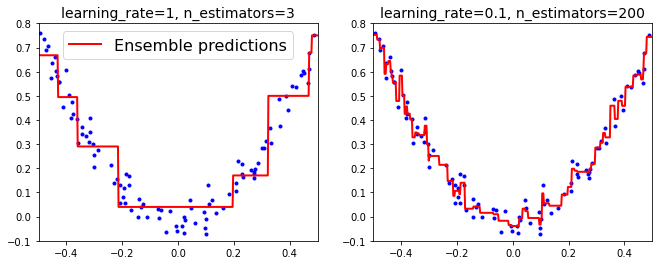

In [28]:
plt.figure(figsize=(11,4))

plt.subplot(121)
plot_predictions([gbrt], X, y, axes=[-0.5, 0.5, -0.1, 0.8], label="Ensemble predictions")
plt.title("learning_rate={}, n_estimators={}".format(gbrt.learning_rate, gbrt.n_estimators), fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_slow], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("learning_rate={}, n_estimators={}".format(gbrt_slow.learning_rate, gbrt_slow.n_estimators), fontsize=14)

plt.show()

**최적의 트리 수를 찾기 위해** 조기 종료 기법을 사용할 수 있다.

다음 코드는 120개의 트리로 GBRT 앙상블을 훈련시키고 최적의 트리 수를 찾기 위해 각 훈련 단계에서 검증 오차를 측정합니다. 마지막에 최적의 트리 수를 사용해 새로운 GBRT 앙상블을 훈련시킵니다.

- ```staged_predict()```: Predict regression target at each stage for X.
- ```argmin```: 함수 f(x)를 최소 값으로 만들기 위한 x 값을 구한다.

In [29]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

X_train, X_val, y_train, y_val = train_test_split(X, y)

gbrt = GradientBoostingRegressor(max_depth=2, n_estimators=120)
gbrt.fit(X_train, y_train)

# 최적의 트리 개수 찾기
errors = [mean_squared_error(y_val, y_pred)
         for y_pred in gbrt.staged_predict(X_val)]  #staged_predict() 메소드
bst_n_estimators = np.argmin(errors) + 1
# np.argim(array) : array에서 최솟값의 인덱스를 반환
# 즉, 최소값을 갖게하는 인덱스로 최적 트리의 수를 판단

# 최적의 트리 개수로 그래이디언트 부스팅 학습
gbrt_best = GradientBoostingRegressor(max_depth=2, n_estimators=bst_n_estimators)
gbrt_best.fit(X_train, y_train)

GradientBoostingRegressor(max_depth=2, n_estimators=53)

학습 과정에서 최적의 트리 개수를 찾았을 때, 학습을 조기종료 하는 예제(오차를 계속해서 줄이다가 5번 이상 줄어들지 않는다면 조기 종료를 시킴).

In [30]:
gbrt = GradientBoostingRegressor(max_depth=2, warm_start=True, random_state=42)     #warm_start=True

min_val_error = float("inf")
error_going_up = 0
for n_estimators in range(1, 120):
    gbrt.n_estimators = n_estimators
    gbrt.fit(X_train, y_train)
    y_pred = gbrt.predict(X_val)
    val_error = mean_squared_error(y_val, y_pred)
    if val_error < min_val_error:           # 초기 min_val_error는 무한대(inf)
        min_val_error = val_error           # 누적
        error_going_up = 0                  # 연속해서 5번이나 MSE가 기존보다 크면
    else:
        error_going_up += 1
        if error_going_up == 5:
            break                          # 조기 종료

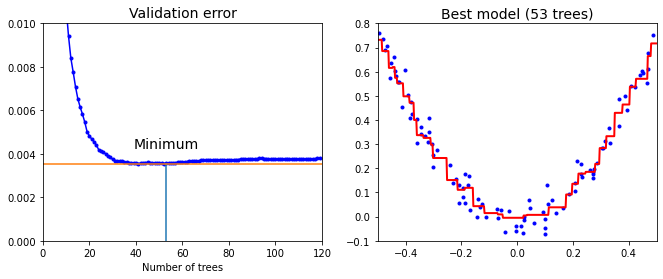

In [31]:
min_error = np.min(errors)

plt.figure(figsize=(11, 4))

plt.subplot(121)
plt.plot(errors, "b.-")
plt.plot([bst_n_estimators, bst_n_estimators], [0, min_error])
plt.plot([0, 120], [min_error, min_error])
plt.plot(bst_n_estimators, min_error)
plt.text(bst_n_estimators, min_error*1.2, "Minimum", ha="center", fontsize=14)
plt.axis([0, 120, 0, 0.01])
plt.xlabel("Number of trees")
plt.title("Validation error", fontsize=14)

plt.subplot(122)
plot_predictions([gbrt_best], X, y, axes=[-0.5, 0.5, -0.1, 0.8])
plt.title("Best model (%d trees)" % bst_n_estimators, fontsize=14)

plt.show()

In [32]:
print('최적의 트리 개수 :', gbrt.n_estimators)
print("최소 검증 MSE:", min_val_error)

최적의 트리 개수 : 47
최소 검증 MSE: 0.003554071291988297


# 7.6 스태킹
앙상블 학습에서 각 모델의 예측값을 가지고 새로운 **블렌더** 또는 **메타 학습기**를 학습시켜 최종 예측 모델을 만드는 방법.

* 원본 데이터의 train, test 데이터셋 존재
* 원본 training data를 3개의 머신러닝 모델이 학습
* 각 모델마다 X_test를 넣어서 예측 후 predict를 뽑아냄 (3개의 predict된 값)
* 3개의 predict를 다시 학습 데이터로 사용
* 최종 모델(블렌더/메타 학습기)를 선정해 학습
* 최종 평가

--------------------------------
### 앙상블 학습의 유형
**1. 보팅**
- 직접 투표
- 간접 투표

**2. 배깅 & 페이스팅**
- oob 평가

**3. 부스팅**
- 1) 에이다부스트
- 2) 그레이디언트 부스팅

**4. 스태킹**

-----------------------------
### 앙상블 모델

**1. 랜덤 포레스트**
- 엑스트라 트리
- 특성 중요도